<a href="https://colab.research.google.com/github/diogobortolini/CI1030-Ciencia-de-Dados-para-Seguranca/blob/main/Projeto_CienciaDados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***01 - Importando Módulos Python***

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn import preprocessing
import matplotlib.pyplot as plt
#plt.style.use("ggplot")
%matplotlib inline
print('OK')

OK


# ***02-Importando do Github e Pré-Processamento***

In [ ]:
### IMPORTANDO DO GITHUB ###
dataset = ('https://raw.githubusercontent.com/diogobortolini/CI1030-Ciencia-de-Dados-para-Seguranca/main/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv') # dataset das amotras de ataques 
dataframe = pd.read_csv(dataset, engine='python', encoding='cp1252') # engine and encoding fix error: UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position xx: invalid start byte
print(dataframe.shape) # Dataset Size

### IMPORTANDO DO DRIVE ###
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#dataset = '/content/drive/My Drive/Colab Notebooks/projetoSeg/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'

### Data PRE-PROCESSING ###
dataframe.columns = dataframe.columns.str.strip() #Clean columns remove or strip the leading and trailing space
dataframe['Label'].unique() #Show Lables

dataframe = dataframe.drop(columns=['Fwd Header Length.1']) #remove repeated column 'Fwd Header Length.1' from 'Fwd Header Length'
print(dataframe.shape) # Dataset Size

dataframe = dataframe.drop(dataframe[pd.isnull(dataframe['Flow ID'])].index) #Remove null/blank data
print(dataframe.shape) # Dataset Size

dataframe.replace('Infinity', -1, inplace=True) #Tranform data -inf
dataframe[["Flow Bytes/s", "Flow Packets/s"]] = dataframe[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric) #Fix error data type non-numeric
dataframe.replace([np.inf, -np.inf, np.nan], -1, inplace=True) #Change INf and NAN to -1

StrToLencoder = list(dataframe.select_dtypes(include=['object']).columns)  #String Columns list
StrToLencoder.remove('Label') #Remove Label string
print(StrToLencoder) #Show string columns

lencoder = sk.preprocessing.LabelEncoder()  #LabelEncoder: string to int
dataframe[StrToLencoder] = dataframe[StrToLencoder].apply(lambda col: lencoder.fit_transform(col)) #Apply LabelEncoder

totalbenign = len(dataframe[dataframe['Label'] == "BENIGN"]) #Bening traffic total
print(totalbenign)
totalattack = len(dataframe[dataframe['Label'] != "BENIGN"]) #Attack traffic total
print(totalattack)

(458968, 85)
Mounted at /content/drive
(458968, 84)
(170366, 84)
['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
168186
2180


# ***03-Analisando os dados***

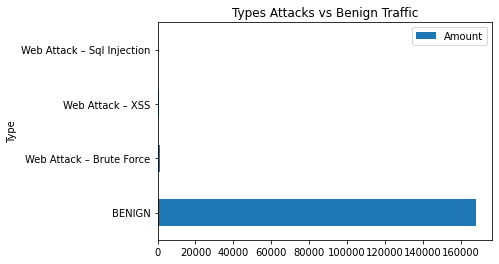

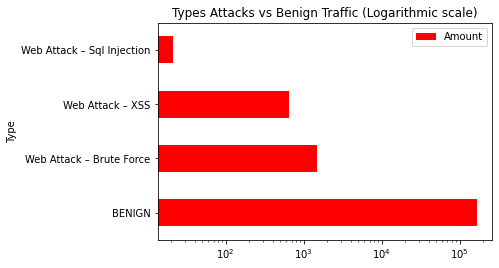

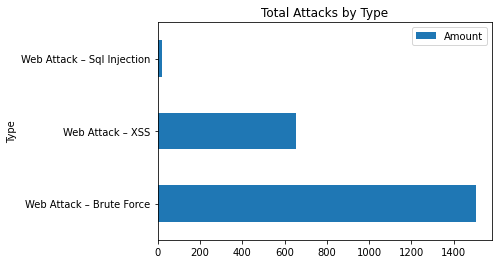

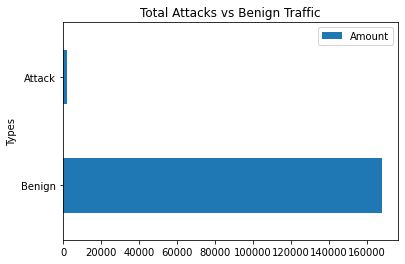

In [ ]:
### View attacks values ###
df = dataframe['Label'].value_counts().rename_axis('Type').reset_index(name='Amount') #Convert Series to Dataframe

df.plot(x='Type', y='Amount', kind='barh', title="Types Attacks vs Benign Traffic") #Plot total Attacks or Benign Traffic
df.plot( x='Type', y='Amount', kind='barh', color='red', title="Types Attacks vs Benign Traffic (Logarithmic scale)", logx=True) #Plot total Attacks or Benign Traffic in Logarithmic scale
df.drop([0]).plot(x='Type', y='Amount', kind='barh', title="Total Attacks by Type" ) #Plot Total Attacks

#Create dataframe with Benign Traffic vs Attack Traffic
data = np.array([['Benign',totalbenign],['Attack',totalattack]])
df2 = pd.DataFrame(data, columns = ['Types', 'Amount'])
df2.Amount=pd.to_numeric(df2.Amount)
df2.plot(x='Types', y='Amount', kind='barh', title="Total Attacks vs Benign Traffic" )

# ***04-Exclusão de Dados***

In [ ]:
# Removed irrelevant columns to analysis, FlowID is just a traffic ID. The Source Port, Destination IP, Destination Port and Protocol columns are based on the capture environment
# Timestamp is just the record of the data and time of the attack.
delete = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']  
dfclean = dataframe.drop(columns=delete, errors='ignore')

#Save Unbalanced Data
dataframe.to_csv('dataUnbalanced.csv', index=False)
!cp dataUnbalanced.csv "/content/drive/My Drive/Colab Notebooks/projetoSeg/"



# ***05-Balanceando os Dados***

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

dfb = dfclean.copy() #Dataframe copy
undersample = RandomUnderSampler(sampling_strategy=0.42) #Set undersample strategy
dfb['Label'] = dfb['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1) # Change Label to 0 if Traffic "Benign" and 1 to Attack
y = dfb['Label'].values #Define Y = Label
X = dfb.drop(columns=['Label']) #Define X = Values (Except Label)
print(X.shape, y.shape)#Dataframe Size
print(Counter(y)) #Counter({0: 168186, 1: 2180})
X_under, y_under = undersample.fit_resample(X, y) #Generate unsersample
print(Counter(y_under)) #Counter({0: 5450, 1: 2180}) Summarize class distribuitation  after undersample

uniques, counts = np.unique(y_under, return_counts=True)
percentages = dict(zip(uniques, counts * 100 / len(y_under)))
print(percentages) # Distribuitation classes after undersample

#Save Balanced Data
dfbalanced = pd.DataFrame(X_under)
dfbalanced['Label'] = y_under
dfbalanced.to_csv('dataBalanced.csv', index=False)
!cp dataBalanced.csv "/content/drive/My Drive/Colab Notebooks/projetoSeg/"

(170366, 76) (170366,)
Counter({0: 168186, 1: 2180})
Counter({0: 5190, 1: 2180})
{0: 70.42062415196743, 1: 29.579375848032566}


# ***06-Definindo Treino e Teste***

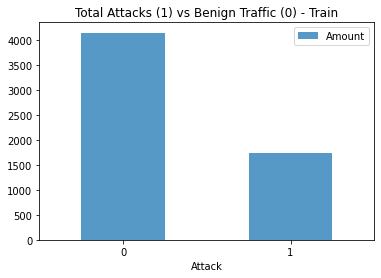

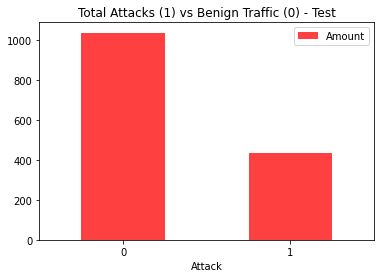

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, stratify=y_under, random_state=1) #Train: 80% and Test: 20%

#Create a plot of Train Set
unique, counts = np.unique(y_train, return_counts=True)
dfdist = dict(zip(unique, counts))
dfdist=pd.DataFrame(dfdist.items(), columns=['Attack', 'Amount'])
dfdist.plot(x='Attack', y='Amount', kind='bar', title="Total Attacks (1) vs Benign Traffic (0) - Train", alpha=0.75, rot=0 )

#Create a plot of Test Set
unique2, counts2 = np.unique(y_test, return_counts=True)
dfdist2 = dict(zip(unique2, counts2))
dfdist2=pd.DataFrame(dfdist2.items(), columns=['Attack', 'Amount'])
dfdist2.plot(x='Attack', y='Amount', kind='bar', color='red', title="Total Attacks (1) vs Benign Traffic (0) - Test", alpha=0.75, rot=0 )


# ***07-Tunning Models*** (Demora em torno de 15m)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

#Tunning do KNN
grid_paramsKNN = {
      'n_neighbors': [3,5,7,11,13,19],
      'weights': ['uniform', 'distance'],
      'metric':['euclidean','manhattan']
}

gsKNN = GridSearchCV(
    KNeighborsClassifier(),
    grid_paramsKNN,
    verbose=1,
    n_jobs=-1,
    scoring='recall'
)
gs_resultsKNN = gsKNN.fit(X_train, y_train)

print(gs_resultsKNN.best_score_)
print(gs_resultsKNN.best_params_)
#print(gs_resultsKNN.best_estimator_)

#Tunning RandomForest
grid_paramsRF = {
    "max_depth": [4, 5, 6, 8],
    "max_features": ["auto", "log2"],
    "n_estimators": [20, 50, 100]
}
gsRF = GridSearchCV(
    RandomForestClassifier(),
    grid_paramsRF,
    verbose=1,
    n_jobs=-1,
    scoring='recall'
)
gs_resultsRF = gsRF.fit(X_train, y_train)

print(gs_resultsRF.best_score_)
print(gs_resultsRF.best_params_)
#print(gs_resultsRF.best_estimator_)

#Tunning do MLP
grid_paramsMLP = {
    'hidden_layer_sizes': [(10,30,10),(20,),(256,128,64,32)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}

gsMLP = GridSearchCV(
    MLPClassifier(max_iter=100),
    grid_paramsMLP,
    verbose=1,
    n_jobs=-1,
    scoring='recall'
)
gs_resultsMLP = gsMLP.fit(X_train, y_train)

print(gs_resultsMLP.best_score_)
print(gs_resultsMLP.best_params_)
#print(gs_resultsMLP.best_estimator_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.9805141125712215
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.9994269340974211
{'max_depth': 8, 'max_features': 'auto', 'n_estimators': 100}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
0.966753943944933
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (20,), 'learning_rate': 'adaptive', 'solver': 'adam'}


# ***08-Aplicando os algoritmo de ML***

# **KNN**

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1038
           1       0.96      0.99      0.97       436

    accuracy                           0.98      1474
   macro avg       0.97      0.98      0.98      1474
weighted avg       0.98      0.98      0.98      1474

Confusion Matrix:
[[1018   20]
 [   6  430]]


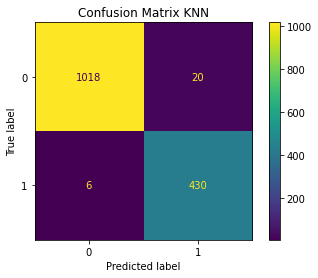

Mean Acuracy: 0.98 | std: 0.0071
Mean Precision: 0.96 | std: 0.0088
Mean Recall: 0.98 | std: 0.018
Mean F1Score: 0.97 | std: 0.012
Confusion Matrix kfold:
[[5106   84]
 [  50 2130]]


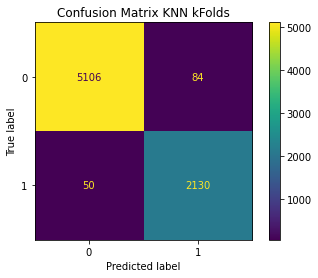

0.9911913789750932


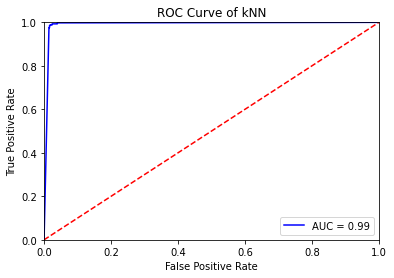

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score


knn = KNeighborsClassifier(**gs_resultsKNN.best_params_).fit(X_train, y_train) #Running KNN whit Tunning parameters
knn2 = KNeighborsClassifier(**gs_resultsKNN.best_params_)

#KNN train (80% dataset) and test (20% dataset)
predictedKNN=knn.predict(X_test) #Predict dataset 80/20
print(classification_report(y_test, predictedKNN, labels=[0,1]))
matrixKNN = confusion_matrix(y_test, predictedKNN)
print("Confusion Matrix:")
print(matrixKNN)

# Plot Confusion Matrix KNN
cm = confusion_matrix(y_test, predictedKNN, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.title('Confusion Matrix KNN')
plt.show()

#Set KFold
scoresKNN = cross_val_score(knn2, X_under, y_under, cv=5, scoring='accuracy') #Accuracy 
print('Mean Acuracy: {:.2} | std: {:.2}'.format(np.mean(scoresKNN), np.std(scoresKNN)))
scoresKNN = cross_val_score(knn2, X_under, y_under, cv=5, scoring='precision') #Precision 
print('Mean Precision: {:.2} | std: {:.2}'.format(np.mean(scoresKNN), np.std(scoresKNN)))
scoresKNN = cross_val_score(knn2, X_under, y_under, cv=5, scoring='recall') #Recall 
print('Mean Recall: {:.2} | std: {:.2}'.format(np.mean(scoresKNN), np.std(scoresKNN)))
scoresKNN = cross_val_score(knn2, X_under, y_under, cv=5, scoring='f1') #F1 Score 
print('Mean F1Score: {:.2} | std: {:.2}'.format(np.mean(scoresKNN), np.std(scoresKNN)))

#Kfold Predicao
predicted2KNN = cross_val_predict(knn2, X_under, y_under, cv=5)
matrixKNNk = confusion_matrix(y_under, predicted2KNN)
print("Confusion Matrix kfold:")
print(matrixKNNk)

# Plot Confusion Matrix KNN
cm = confusion_matrix(y_under, predicted2KNN, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix KNN kFolds')
plt.show()

#ROC
probs = knn.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

#yhat = knn.predict(X_test)
#lr_precision, lr_recall, _ = precision_recall_curve(y_test, preds)
#lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)
## summarize scores
#print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
## plot the precision-recall curves
#no_skill = len(y_test[y_test==1]) / len(y_test)
#plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
#plt.plot(lr_recall, lr_precision, marker='.', label='knn')
## axis labels
#plt.xlabel('Recall')
#plt.ylabel('Precision')
## show the legend
#plt.legend()
#plt.show()

# **Random Forest**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1038
           1       0.99      1.00      0.99       436

    accuracy                           1.00      1474
   macro avg       1.00      1.00      1.00      1474
weighted avg       1.00      1.00      1.00      1474

Confusion Matrix:
[[1035    3]
 [   2  434]]


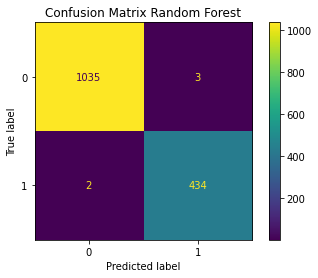

Mean Acuracy: 0.99 | Desvio: 0.0069
Mean Precision: 0.99 | Desvio: 0.0026
Mean Recall: 0.97 | Desvio: 0.021
Mean F1 Score: 0.98 | Desvio: 0.013
Confusion Matrix kfold:
[[5167   23]
 [  57 2123]]


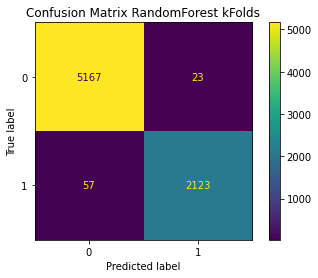

0.9998828905269485


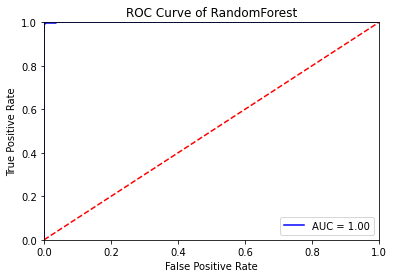

In [ ]:
from sklearn.ensemble  import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

rfc = RandomForestClassifier(**gs_resultsRF.best_params_).fit(X_train, y_train) #Running RandomForest whit Tunning parameters
rfc2 = RandomForestClassifier(**gs_resultsRF.best_params_)

#RandomForest train (80% dataset) and test (20% dataset)
predictedRFC=rfc.predict(X_test)  #Predict dataset 80/20
print(classification_report(y_test, predictedRFC, labels=[0,1]))
matrixRF = confusion_matrix(y_test, predictedRFC)
print("Confusion Matrix:")
print(matrixRF)

# Plot Confusion Matrix RF
cmRFC = confusion_matrix(y_test, predictedRFC, labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmRFC, display_labels=rfc.classes_)
disp.plot()
plt.title('Confusion Matrix Random Forest')
plt.show()

#Set KFold Results
scoresRFC = cross_val_score(rfc2, X_under, y_under, cv=5, scoring='accuracy') #Accuracy 
print('Mean Acuracy: {:.2} | Desvio: {:.2}'.format(np.mean(scoresRFC), np.std(scoresRFC)))
scoresRFC = cross_val_score(rfc2, X_under, y_under, cv=5, scoring='precision') #precision 
print('Mean Precision: {:.2} | Desvio: {:.2}'.format(np.mean(scoresRFC), np.std(scoresRFC)))
scoresRFC = cross_val_score(rfc2, X_under, y_under, cv=5, scoring='recall') #Recall 
print('Mean Recall: {:.2} | Desvio: {:.2}'.format(np.mean(scoresRFC), np.std(scoresRFC)))
scoresRFC = cross_val_score(rfc2, X_under, y_under, cv=5, scoring='f1') #F1 Score 
print('Mean F1 Score: {:.2} | Desvio: {:.2}'.format(np.mean(scoresRFC), np.std(scoresRFC)))


#Kfold Predict
predicted2RFC = cross_val_predict(rfc2, X_under, y_under, cv=5)
matrixRFCk = confusion_matrix(y_under, predicted2RFC)
print("Confusion Matrix kfold:")
print(matrixRFCk)

# Plot Confusion Matrix RF
cmRFC = confusion_matrix(y_under, predicted2RFC)
disp = ConfusionMatrixDisplay(confusion_matrix=cmRFC)
disp.plot()
plt.title('Confusion Matrix RandomForest kFolds')
plt.show()

#ROC
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_aucRFC = auc(fpr, tpr)
print(roc_aucRFC)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_aucRFC)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of RandomForest')
plt.show()

# **MLP Classificator**

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1038
           1       0.90      1.00      0.95       436

    accuracy                           0.97      1474
   macro avg       0.95      0.98      0.96      1474
weighted avg       0.97      0.97      0.97      1474

Confusion Matrix:
[[991  47]
 [  2 434]]


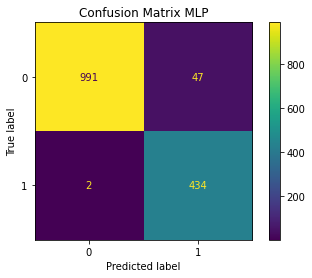

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Acurácia Média: 0.96 | Desvio: 0.0043


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Precisão Média: 0.93 | Desvio: 0.024
Revocação Média: 0.97 | Desvio: 0.018


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


F1 Score Média: 0.94 | Desvio: 0.0077


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Confusion Matrix kfold:
[[5045  145]
 [ 131 2049]]


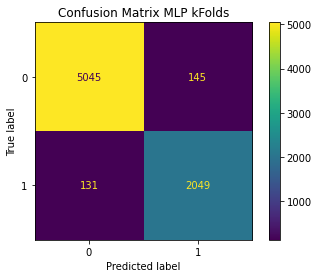

0.9918885117816549


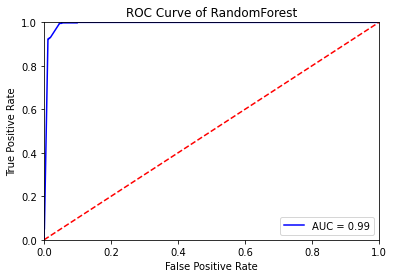

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

mlp = MLPClassifier(**gs_resultsMLP.best_params_).fit(X_train, y_train) #Running MLP whit Tunning parameters
mlp2 = MLPClassifier(**gs_resultsMLP.best_params_)

#MLP train (80% dataset) and test (20% dataset)
predictedMLP=mlp.predict(X_test) #Predict dataset 80/20
print(classification_report(y_test, predictedMLP, labels=[0,1]))
matrixMLP = confusion_matrix(y_test, predictedMLP)
print("Confusion Matrix:")
print(matrixMLP)

# Plot Confusion Matrix
cmMLP = confusion_matrix(y_test, predictedMLP, labels=mlp.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmMLP, display_labels=mlp.classes_)
disp.plot()
plt.title('Confusion Matrix MLP')
plt.show()

#Set KFold, Results
scoresMLP = cross_val_score(mlp2, X_under, y_under, cv=5, scoring='accuracy') #Accuracy 
print('Acurácia Média: {:.2} | Desvio: {:.2}'.format(np.mean(scoresMLP), np.std(scoresMLP)))
scoresMLP = cross_val_score(mlp2, X_under, y_under, cv=5, scoring='precision') #precision 
print('Precisão Média: {:.2} | Desvio: {:.2}'.format(np.mean(scoresMLP), np.std(scoresMLP)))
scoresMLP = cross_val_score(mlp2, X_under, y_under, cv=5, scoring='recall') #Recall 
print('Revocação Média: {:.2} | Desvio: {:.2}'.format(np.mean(scoresMLP), np.std(scoresMLP)))
scoresMLP = cross_val_score(mlp2, X_under, y_under, cv=5, scoring='f1') #F1 Score 
print('F1 Score Média: {:.2} | Desvio: {:.2}'.format(np.mean(scoresMLP), np.std(scoresMLP)))

#Kfold Predict
predicted2MLP = cross_val_predict(mlp2, X_under, y_under, cv=5)
matrixMLPk = confusion_matrix(y_under, predicted2MLP)
print("Confusion Matrix kfold:")
print(matrixMLPk)

#Plot Confusion Matrix
cmMLP = confusion_matrix(y_under, predicted2MLP)
disp = ConfusionMatrixDisplay(confusion_matrix=cmMLP)
disp.plot()
plt.title('Confusion Matrix MLP Folds')
plt.show()

#ROC
probs = mlp.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_aucMLP = auc(fpr, tpr)
print(roc_aucMLP)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_aucMLP)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of RandomForest')
plt.show()








#fig=plot_confusion_matrix(clfMLP, X_testscaled, y_test,display_labels=["0","1"])
#fig.figure_.suptitle("Confusion Matrix for MLP")
#plt.show()
#print(classification_report(y_test, predictedMLP, labels=[0,1]))

***SPEC COLAB***

In [ ]:
!cat /proc/cpuinfo
!cat /proc/meminfo